In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from math import pi
from datetime import datetime  as dt
import matplotlib
import networkx as nx

# Import API key
from api_keys import api_key
single_city_url = "http://api.openweathermap.org/data/2.5/weather?"

## Bokeh imports

In [42]:
#import bokeh for analysis of datasets.
from bokeh.models import DatetimeTickFormatter
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models.tools import HoverTool
import bokeh.palettes as bcolors
from bokeh.transform import factor_cmap
import matplotlib.dates as mdates

# For color scatter
#from bokeh.charts import Scatter, output_file, show

In [43]:
output_notebook()

Loading BokehJS ...

In [44]:
city_name = "portland"
city_id = "5746545"
city_units = "metric"
covid = "mobility-trends.csv"

In [45]:
covid_df = pd.read_csv(covid)

In [46]:
covid_df

,geo_type,region,transportation_type,date,value
0,country/region,Albania,driving,2020-01-13,100.00
1,country/region,Albania,driving,2020-01-14,95.30
2,country/region,Albania,driving,2020-01-15,101.43
3,country/region,Albania,driving,2020-01-16,97.20
4,country/region,Albania,driving,2020-01-17,103.55
...,...,...,...,...,...
41470,city,Zurich,walking,2020-04-22,72.35
41471,city,Zurich,walking,2020-04-23,73.64
41472,city,Zurich,walking,2020-04-24,76.72
41473,city,Zurich,walking,2020-04-25,78.56


## data cleaning

In [47]:
covcopy = covid_df.copy()

In [48]:
region_type_list = covid_df['geo_type'].unique()

In [49]:
move_type_list = covid_df['transportation_type'].unique()

In [50]:
move_type_list

array(['driving', 'walking', 'transit'], dtype=object)

In [51]:
region_list_city = covid_df.loc[covid_df['geo_type'] == "city"]['region'].unique()

### Build Color Column

In [52]:
color_profile = {'driving':"darkgoldenrod", 'walking':"green", 'transit':"salmon"}

In [53]:
color_list = []
for activity in covid_df["transportation_type"]:
    color_list.append(color_profile[activity])

covid_df['cyl'] = color_list

## Isolate regions by type - city

In [54]:
region_list_city

array(['Amsterdam', 'Athens', 'Atlanta', 'Auckland', 'Baltimore',
       'Bangkok', 'Barcelona', 'Berlin', 'Birmingham - UK',
       'Bochum - Dortmund', 'Boston', 'Brisbane', 'Brussels',
       'Buenos Aires', 'Cairo', 'Calgary', 'Cape Town', 'Chicago',
       'Cologne', 'Copenhagen', 'Dallas', 'Delhi', 'Denver', 'Detroit',
       'Dubai', 'Dublin', 'Dusseldorf', 'Edmonton', 'Frankfurt',
       'Fukuoka', 'Guadalajara', 'Halifax', 'Hamburg', 'Helsinki',
       'Houston', 'Hsin-chu', 'Istanbul', 'Jakarta', 'Johannesburg',
       'Kuala Lumpur', 'Leeds', 'Lille', 'London', 'Los Angeles', 'Lyon',
       'Madrid', 'Manchester', 'Manila', 'Melbourne', 'Mexico City',
       'Miami', 'Milan', 'Montreal', 'Moscow', 'Mumbai', 'Munich',
       'Nagoya', 'New York City', 'Osaka', 'Oslo', 'Ottawa', 'Paris',
       'Perth', 'Philadelphia', 'Rio de Janeiro', 'Riyadh', 'Rome',
       'Rotterdam', 'Saint Petersburg', 'San Francisco - Bay Area',
       'Santiago', 'Sao Paulo', 'Seattle', 'Seoul', 'Sto

In [55]:
region_list_country = covid_df.loc[covid_df['geo_type'] == "country/region"]['region'].unique()

## Isolate region by country/other.

In [56]:
region_list_country

array(['Albania', 'Argentina', 'Australia', 'Austria', 'Belgium',
       'Brazil', 'Bulgaria', 'Cambodia', 'Canada', 'Chile', 'Colombia',
       'Croatia', 'Czech Republic', 'Denmark', 'Egypt', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hong Kong', 'Hungary',
       'Iceland', 'India', 'Indonesia', 'Ireland', 'Israel', 'Italy',
       'Japan', 'Latvia', 'Lithuania', 'Luxembourg', 'Macao', 'Malaysia',
       'Mexico', 'Morocco', 'Netherlands', 'New Zealand', 'Norway',
       'Philippines', 'Poland', 'Portugal', 'Republic of Korea',
       'Romania', 'Russia', 'Saudi Arabia', 'Serbia', 'Singapore',
       'Slovakia', 'Slovenia', 'South Africa', 'Spain', 'Sweden',
       'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'UK',
       'United States', 'Ukraine', 'United Arab Emirates', 'Uruguay',
       'Vietnam'], dtype=object)

## Build list of stats for each region and movement type: 'driving', 'walking', 'transit'.

In [57]:
stats_summary_list = []
for city in region_list_city:
    for move in move_type_list:
        def region_filter(df):
            return ((df['geo_type'] == 'city')&(df['region'] == city))
        sub_region = covid_df.loc[region_filter]
        stats_summary_list.append({'geo_type':'city','region':city,'transportation_type':move,'summary':sub_region.loc[sub_region['transportation_type']==move].describe(include='all')})
     

In [58]:
stats_summary_list[0]['summary']['value']['mean']

78.32666666666664

In [59]:
for country in region_list_country:
    for move in move_type_list:
        def region_filter(df):
            return ((df['geo_type'] == 'country/region')&(df['region'] == country))
        sub_region = covid_df.loc[region_filter]
        stats_summary_list.append({'geo_type':'country/region','region':country,'transportation_type':move,'summary':sub_region.loc[sub_region['transportation_type']==move].describe(include='all')})

In [60]:
stats_summary_list[0]['summary']['value']

count     105.000000
unique           NaN
top              NaN
freq             NaN
mean       78.326667
std        31.837352
min        30.960000
25%        42.630000
50%        94.420000
75%       105.710000
max       122.190000
Name: value, dtype: float64

In [61]:
stats_summary_all = []
for stats in stats_summary_list:
    stats_summary_all.append({'geo_type':stats['geo_type'],'region':stats['region'],'transportation_type':stats['transportation_type'],
                             'count':stats['summary']['value']['count'],'mean':stats['summary']['value']['mean'],
                             'std':stats['summary']['value']['std'],'min':stats['summary']['value']['min'],
                             '25%':stats['summary']['value']['25%'],'50%':stats['summary']['value']['50%'],
                             '75%':stats['summary']['value']['75%'],'max':stats['summary']['value']['max']})


In [62]:
stats_df = pd.DataFrame(stats_summary_all)

In [63]:
stats_df.head(5)

,geo_type,region,transportation_type,count,mean,std,min,25%,50%,75%,max
0,city,Amsterdam,driving,105.0,78.326667,31.837352,30.96,42.63,94.42,105.71,122.19
1,city,Amsterdam,walking,105.0,83.307333,52.621331,17.18,27.15,97.38,119.62,193.16
2,city,Amsterdam,transit,105.0,74.856667,53.001379,10.58,13.64,100.09,119.73,154.58
3,city,Athens,driving,105.0,70.950190,38.509364,16.72,29.67,93.77,104.47,128.98
4,city,Athens,walking,105.0,79.001619,44.355661,16.61,33.92,95.28,115.56,160.65


In [64]:
below_std = stats_df.loc[stats_df['std'] < 17]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D45AF7D588>]],
      dtype=object)

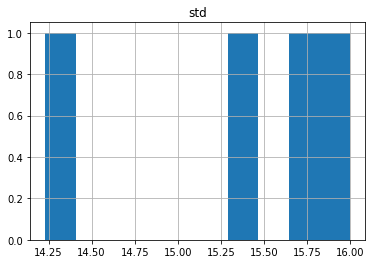

In [65]:
below_std.hist(column='std')

In [66]:
below_std

,geo_type,region,transportation_type,count,mean,std,min,25%,50%,75%,max
222,city,Stockholm,driving,105.0,96.347048,15.337080,65.31,83.70,99.26,105.88,128.02
231,city,Taichung,driving,105.0,105.702476,15.997029,73.63,96.10,105.06,115.81,140.02
234,city,Taipei,driving,105.0,96.987619,14.231273,71.85,86.75,95.92,106.14,130.22
423,country/region,Sweden,driving,105.0,105.113810,15.706212,76.70,92.71,105.29,115.86,140.44


In [67]:
below = stats_df.loc[stats_df['min'] < 15]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D45B0B54E0>]],
      dtype=object)

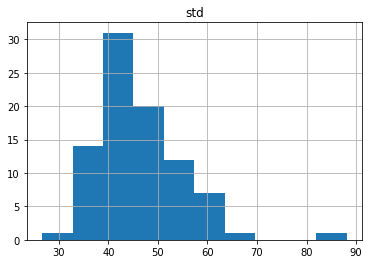

In [68]:
below.hist(column='std')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D45B0D95C0>]],
      dtype=object)

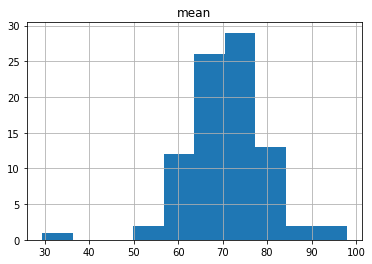

In [69]:
below.hist(column='mean')

In [70]:
below

,geo_type,region,transportation_type,count,mean,std,min,25%,50%,75%,max
2,city,Amsterdam,transit,105.0,74.856667,53.001379,10.58,13.64,100.09,119.73,154.58
9,city,Auckland,driving,105.0,73.330952,42.588335,11.32,16.92,88.15,109.03,140.04
11,city,Auckland,transit,105.0,72.714857,46.886617,8.08,11.55,98.10,111.15,133.10
18,city,Barcelona,driving,105.0,71.914762,50.663900,8.70,13.89,100.00,113.82,148.90
19,city,Barcelona,walking,105.0,73.006000,59.441884,3.78,6.35,100.00,121.01,187.46
...,...,...,...,...,...,...,...,...,...,...,...
421,country/region,Spain,walking,105.0,77.879333,60.930860,5.82,10.12,100.74,125.56,192.60
422,country/region,Spain,transit,105.0,73.129429,56.633930,7.04,9.26,101.88,122.48,160.56
436,country/region,Turkey,walking,105.0,81.768857,44.109665,14.23,32.49,102.85,113.95,181.98
440,country/region,UK,transit,105.0,73.074381,44.264420,13.50,16.96,100.52,108.51,126.90


In [71]:
stats_summary_all

[{'geo_type': 'city',
  'region': 'Amsterdam',
  'transportation_type': 'driving',
  'count': 105.0,
  'mean': 78.32666666666664,
  'std': 31.837352387585273,
  'min': 30.96,
  '25%': 42.63,
  '50%': 94.42,
  '75%': 105.71,
  'max': 122.19},
 {'geo_type': 'city',
  'region': 'Amsterdam',
  'transportation_type': 'walking',
  'count': 105.0,
  'mean': 83.30733333333336,
  'std': 52.6213306096321,
  'min': 17.18,
  '25%': 27.15,
  '50%': 97.38,
  '75%': 119.62,
  'max': 193.16},
 {'geo_type': 'city',
  'region': 'Amsterdam',
  'transportation_type': 'transit',
  'count': 105.0,
  'mean': 74.85666666666667,
  'std': 53.00137853190285,
  'min': 10.58,
  '25%': 13.64,
  '50%': 100.09,
  '75%': 119.73,
  'max': 154.58},
 {'geo_type': 'city',
  'region': 'Athens',
  'transportation_type': 'driving',
  'count': 105.0,
  'mean': 70.9501904761905,
  'std': 38.50936437016508,
  'min': 16.72,
  '25%': 29.67,
  '50%': 93.77,
  '75%': 104.47,
  'max': 128.98},
 {'geo_type': 'city',
  'region': 'Athe

In [72]:
city_df =  covid_df.loc[covid_df['geo_type'] == "city"]
city_df

,geo_type,region,transportation_type,date,value,cyl
16065,city,Amsterdam,driving,2020-01-13,100.00,darkgoldenrod
16066,city,Amsterdam,driving,2020-01-14,103.53,darkgoldenrod
16067,city,Amsterdam,driving,2020-01-15,104.23,darkgoldenrod
16068,city,Amsterdam,driving,2020-01-16,103.92,darkgoldenrod
16069,city,Amsterdam,driving,2020-01-17,111.95,darkgoldenrod
...,...,...,...,...,...,...
41470,city,Zurich,walking,2020-04-22,72.35,green
41471,city,Zurich,walking,2020-04-23,73.64,green
41472,city,Zurich,walking,2020-04-24,76.72,green
41473,city,Zurich,walking,2020-04-25,78.56,green


In [73]:
search_city = "Miami"

In [74]:
indy_location = city_df.loc[city_df['region'] == search_city]
indy_location

,geo_type,region,transportation_type,date,value,cyl
30345,city,Miami,driving,2020-01-13,100.00,darkgoldenrod
30346,city,Miami,driving,2020-01-14,103.67,darkgoldenrod
30347,city,Miami,driving,2020-01-15,105.71,darkgoldenrod
30348,city,Miami,driving,2020-01-16,109.05,darkgoldenrod
30349,city,Miami,driving,2020-01-17,126.28,darkgoldenrod
...,...,...,...,...,...,...
30655,city,Miami,walking,2020-04-22,47.92,green
30656,city,Miami,walking,2020-04-23,48.64,green
30657,city,Miami,walking,2020-04-24,51.83,green
30658,city,Miami,walking,2020-04-25,49.63,green


# New Chart Method

In [75]:

scatter_date = []

for date in indy_location['date']:
    scatter_date.append(np.datetime64(dt.strptime(date, "%Y-%m-%d")))

AttributeError: 'list' object has no attribute 'dtypes'

date_groups_3 = []

for date in indy_location_moving[0]['date']:
    date_groups_1.append(np.datetime64(dt.strptime(date, "%Y-%m-%d")))

In [36]:
date_str = []

for date in scatter_date:
    date_str.append(str(date))

In [37]:
# pass plot data as well as hovertool data in to plot.
source_scatter = ColumnDataSource(
        data=dict(
            x=scatter_date,
            y=indy_location['value'],
            color=indy_location['cyl'],
            desc=date_str,
        )
    )

In [38]:
# configure plot tools including the hover tool / tooltips.  Displays date / time of individual data points when hovering 
#over individual points.
TOOLSCCD = [HoverTool(tooltips=[
            ("cvd_date", "@desc"),("cvd_value","$y")],
                  formatters={'DateTime': 'datetime'}),'wheel_zoom','save','crosshair','pan','reset']

In [39]:
cxx = figure(title = f"Values for {search_city}. Movement: All",plot_width=800, plot_height=600,tools=TOOLSCCD,x_axis_type="datetime") #, tooltips=TOOLTIPS
cxx.xaxis.axis_label = 'Event Date'
cxx.yaxis.axis_label = 'COVID Value'
# Setup x axis for using Datetime formatting.
cxx.xaxis.formatter=DatetimeTickFormatter(
        hours=["%d %B %Y"],
        days=["%d %B %Y"],
        months=["%d %B %Y"],
        years=["%d %B %Y"],
    )

cxx.xaxis.major_label_orientation = pi/4
cxx.circle('x', 'y', fill_alpha=0.2, size=10,source=source_scatter)


GlyphRenderer(id='1042', ...)

In [40]:
show(cxx)

In [59]:
indy_location_moving = []
for move_type in move_type_list:
    indy_location_moving.append(indy_location.loc[indy_location['transportation_type'] == move_type])

In [60]:
indy_location_moving[0].describe(include='all')

,geo_type,region,transportation_type,date,value
count,105,105,105,105,105.000000
unique,1,1,1,105,NaN
top,city,Miami,driving,2020-02-25,NaN
freq,105,105,105,1,NaN
mean,NaN,NaN,NaN,NaN,85.003238
std,NaN,NaN,NaN,NaN,32.626278
min,NaN,NaN,NaN,NaN,29.340000
25%,NaN,NaN,NaN,NaN,48.020000
50%,NaN,NaN,NaN,NaN,98.670000
75%,NaN,NaN,NaN,NaN,112.370000


In [61]:
indy_location_moving[1].describe(include='all')

,geo_type,region,transportation_type,date,value
count,105,105,105,105,105.000000
unique,1,1,1,105,NaN
top,city,Miami,walking,2020-02-25,NaN
freq,105,105,105,1,NaN
mean,NaN,NaN,NaN,NaN,90.155429
std,NaN,NaN,NaN,NaN,38.599527
min,NaN,NaN,NaN,NaN,31.650000
25%,NaN,NaN,NaN,NaN,46.770000
50%,NaN,NaN,NaN,NaN,100.000000
75%,NaN,NaN,NaN,NaN,115.570000


In [62]:
indy_location_moving[2].describe(include='all')

,geo_type,region,transportation_type,date,value
count,105,105,105,105,105.000000
unique,1,1,1,105,NaN
top,city,Miami,transit,2020-02-25,NaN
freq,105,105,105,1,NaN
mean,NaN,NaN,NaN,NaN,70.957524
std,NaN,NaN,NaN,NaN,32.351383
min,NaN,NaN,NaN,NaN,22.430000
25%,NaN,NaN,NaN,NaN,31.410000
50%,NaN,NaN,NaN,NaN,87.610000
75%,NaN,NaN,NaN,NaN,100.390000


In [63]:
move_type_list

array(['driving', 'walking', 'transit'], dtype=object)

In [64]:
indy_location.describe(include='all')

,geo_type,region,transportation_type,date,value
count,315,315,315,315,315.000000
unique,1,1,3,105,NaN
top,city,Miami,transit,2020-02-25,NaN
freq,315,315,105,3,NaN
mean,NaN,NaN,NaN,NaN,82.038730
std,NaN,NaN,NaN,NaN,35.478464
min,NaN,NaN,NaN,NaN,22.430000
25%,NaN,NaN,NaN,NaN,45.185000
50%,NaN,NaN,NaN,NaN,96.350000
75%,NaN,NaN,NaN,NaN,107.305000


In [65]:

ref_date = []

for date in indy_location['date']:
    ref_date.append(np.datetime64(dt.strptime(date, "%Y-%m-%d")))

In [66]:
date_groups_1 = []
date_groups_2 = []
date_groups_3 = []

for date in indy_location_moving[0]['date']:
    date_groups_1.append(np.datetime64(dt.strptime(date, "%Y-%m-%d")))
    
for date in indy_location_moving[1]['date']:
    date_groups_2.append(np.datetime64(dt.strptime(date, "%Y-%m-%d")))
    
for date in indy_location_moving[2]['date']:
    date_groups_3.append(np.datetime64(dt.strptime(date, "%Y-%m-%d")))

In [67]:
date_groups = []
for date_set in indy_location_moving:
    for date_ in date_set['date']:
        date_groups.append(np.datetime64(dt.strptime(date_, "%Y-%m-%d")))

In [68]:
date_cvd_1 = []

for date in date_groups_1:
    date_cvd_1.append(str(date))

# pass plot data as well as hovertool data in to plot.
source_cvd_1 = ColumnDataSource(
        data=dict(
            x=date_groups_1,
            y=indy_location_moving[0]['value'],
            desc=date_cvd_1,
        )
    )

In [69]:
date_cvd_2 = []

for date in date_groups_2:
    date_cvd_2.append(str(date))

# pass plot data as well as hovertool data in to plot.
source_cvd_2 = ColumnDataSource(
        data=dict(
            x=date_groups_2,
            y=indy_location_moving[1]['value'],
            desc=date_cvd_2,
        )
    )

In [70]:
date_cvd_3 = []

for date in date_groups_3:
    date_cvd_3.append(str(date))

# pass plot data as well as hovertool data in to plot.
source_cvd_3 = ColumnDataSource(
        data=dict(
            x=date_groups_3,
            y=indy_location_moving[2]['value'],
            desc=date_cvd_3,
        )
    )

In [71]:
grp_color = []
grp_color_palette = bcolors.brewer['Spectral'][6]
#linked_evt_count
for flr in range(6):
    grp_color.append(grp_color_palette[flr])
    

In [72]:
# configure plot tools including the hover tool / tooltips.  Displays date / time of individual data points when hovering 
#over individual points.
TOOLSCCD = [HoverTool(tooltips=[
            ("cvd_date", "@desc"),("cvd_value","$y")],
                  formatters={'DateTime': 'datetime'}),'wheel_zoom','save','crosshair','pan','reset']

In [81]:
cid = figure(title = f"Values for {search_city}. Movement: {move_type_list[0]}",plot_width=800, plot_height=600,tools=TOOLSCCD,x_axis_type="datetime") #, tooltips=TOOLTIPS
cid.xaxis.axis_label = 'Event Date'
cid.yaxis.axis_label = 'COVID Value'
# Setup x axis for using Datetime formatting.
cid.xaxis.formatter=DatetimeTickFormatter(
        hours=["%d %B %Y"],
        days=["%d %B %Y"],
        months=["%d %B %Y"],
        years=["%d %B %Y"],
    )

cid.xaxis.major_label_orientation = pi/4
cid.circle('x', 'y', line_color="navy", fill_color="red", fill_alpha=0.2, size=10,source=source_cvd_1)


GlyphRenderer(id='2896', ...)

In [82]:
show(cid)

In [97]:
cid_2 = figure(title = f"Values for {search_city}. Movement: {move_type_list[1]}",plot_width=800, plot_height=600,tools=TOOLSCCD,x_axis_type="datetime") #, tooltips=TOOLTIPS
cid_2.xaxis.axis_label = 'Event Date'
cid_2.yaxis.axis_label = 'COVID Value'
# Setup x axis for using Datetime formatting.
cid_2.xaxis.formatter=DatetimeTickFormatter(
        hours=["%d %B %Y"],
        days=["%d %B %Y"],
        months=["%d %B %Y"],
        years=["%d %B %Y"],
    )

cid_2.xaxis.major_label_orientation = pi/4
cid_2.circle('x', 'y', fill_color="gold", fill_alpha=0.5, size=10,source=source_cvd_2)


GlyphRenderer(id='5896', ...)

In [98]:
show(cid_2)

##### 

In [85]:
cid_3 = figure(title = f"Values for {search_city}. Movement: {move_type_list[2]}",plot_width=800, plot_height=600,tools=TOOLSCCD,x_axis_type="datetime") #, tooltips=TOOLTIPS
cid_3.xaxis.axis_label = 'Event Date'
cid_3.yaxis.axis_label = 'COVID Value'
# Setup x axis for using Datetime formatting.
cid_3.xaxis.formatter=DatetimeTickFormatter(
        hours=["%d %B %Y"],
        days=["%d %B %Y"],
        months=["%d %B %Y"],
        years=["%d %B %Y"],
    )

cid_3.xaxis.major_label_orientation = pi/4
cid_3.circle('x', 'y', line_color="navy", fill_color="red", fill_alpha=0.2, size=10,source=source_cvd_3)


GlyphRenderer(id='3538', ...)

In [86]:
show(cid_3)